In [10]:
%matplotlib notebook
import mne
import numpy as np

import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn import linear_model
# athenacli -e prod -w3 -n0 -p KET -o . EEGTEST

In [11]:
montage = mne.channels.read_montage('standard_1020')
edf_file = 'eeg0009_raw.edf'
log_file = 'EEG_0009.csv'

In [12]:
raw = mne.io.read_raw_edf(edf_file, stim_channel='Trigger', eog=['EEG X1-Pz'], 
                          misc=['EEG CM-Pz','EEG X2-Pz','EEG X3-Pz'])
# Rename the channels so they match the standard montage channel names
raw.rename_channels({c:c.replace('EEG ','').replace('-Pz','') for c in raw.ch_names})
raw.set_montage(montage)
eeg_sample_interval_ms = 1/raw.info['sfreq'] * 1000
print(raw.info)

Extracting EDF parameters from /Users/ctananbaum/eeg0009_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | P3, C3, F3, Fz, F4, C4, P4, Cz, CM, ...
    chs : list | 25 items (EEG: 20, MISC: 3, EOG: 1, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 23 items (3 Cardinal, 20 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 150.0 Hz
    meas_date : tuple | 2019-07-15 14:48:36 GMT
    nchan : int | 25
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 300.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hp

In [13]:
events = mne.find_events(raw, min_duration=2 / raw.info['sfreq'])

877 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  43  44  45  46  47  48  49  50  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75
  76  77  78  79  80  81  82  83  84  85  86  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 240 241
 242 243 244 245 246 24

In [14]:
events.shape

(877, 3)

In [15]:
logdf = pd.read_csv(log_file, header=None, names=['client_ts','trigger_ts','rtdelay','msg','uid'])
#logdf=logdf[logdf['uid'] == 'Ria']
#logdf=logdf[logdf['msg'] == 'imageFlip']
logdf.client_ts = (logdf.client_ts * 1000).round().astype(int)
logdf.trigger_ts = (logdf.trigger_ts * 1000).round().astype(int)
logdf['bytecode'] = logdf.client_ts % 255 + 1
#logdf = logdf.sort_values('trigger_ts').reset_index(drop=True)
#logdf['trigger_ts'] = logdf['trigger_ts'] + (logdf.at[0, 'client_ts'] - logdf.at[0, 'trigger_ts'])
logdf = logdf[1:] #FOR THE SECOND EEG
#logdf = logdf[5:] #FOR THE FIRST EEG
logdf

,client_ts,trigger_ts,rtdelay,msg,uid,bytecode
1,1563227303265,1563227304670,0,event,2,16
2,1563227318972,1563227319820,0,event,2,168
3,1563227321230,1563227322730,-1,imageFlip,eeg0009,131
4,1563227321977,1563227322798,143,imageFlip,eeg0009,113
5,1563227322728,1563227323609,186,imageFlip,eeg0009,99
6,1563227323479,1563227324339,182,imageFlip,eeg0009,85
7,1563227324226,1563227325390,160,imageFlip,eeg0009,67
8,1563227324978,1563227325864,112,imageFlip,eeg0009,54
9,1563227325727,1563227326579,290,imageFlip,eeg0009,38
10,1563227326478,1563227327414,153,imageFlip,eeg0009,24


In [16]:
eventdf = pd.DataFrame(events, columns=['time_idx','prev_diff','bytecode'])
# NOTE: the eeg timestamp is local time, not UTC! Be sure to use the correct adjustment here.
event_start_ts = int(raw.info['meas_date'][0]) + 7*60*60
eventdf['eeg_ts'] = ((eventdf.time_idx / 300 + event_start_ts) * 1000).round().astype(int)
#eventdf.to_csv('riaJuly8Test1Events.csv')
np.sort(pd.unique(eventdf.bytecode))
#eventdf =eventdf[:340]
bytes1 = logdf['bytecode']
bytes2 = eventdf['bytecode']
x = pd.DataFrame(data=zip(bytes1, bytes2))
x['diff'] = x[0] - x[1]
x

,0,1,diff
0,16,16,0
1,168,168,0
2,131,131,0
3,113,113,0
4,99,99,0
5,85,85,0
6,67,67,0
7,54,54,0
8,38,38,0
9,24,24,0


In [17]:
window = 10000 # +/-, in milliseconds
shift_idx = 0
match_inds = []

#ADD COMPARE FUNCTION TO RETURN TRUE IF BYTECODES ARE EXACTLY EQUAL OR OFF BY FOUR
for event_idx in eventdf.index:
    tmp = logdf.loc[np.abs(eventdf.eeg_ts[event_idx] - logdf.client_ts) < window, :]
    matches = tmp.index[(tmp.bytecode == eventdf.bytecode[event_idx])]
    if len(matches) > 0:
        for match in matches:
            # See if the surrounding bytecodes match. If so, add this to the list
            keep = False
            try:
                keep = True
                for idx in range(-shift_idx,shift_idx+1):
                    if (tmp.bytecode[match + idx] != eventdf.bytecode[event_idx + idx] | tmp.bytecode[match + idx]!=(eventdf.bytecode[event_idx + idx]-4)):
                        keep = False
                        continue
            except:
                #print(tmp.bytecode[match[0]+1], eventdf.bytecode[event_idx+1])
                pass
            if keep:
                match_inds.append((logdf.msg[match], match, event_idx, logdf.trigger_ts[match], logdf.client_ts[match],
                                    eventdf.eeg_ts[event_idx], eventdf.time_idx[event_idx], logdf.rtdelay[match]))
                
print('Found %d matching timepoints.' % len(match_inds))
cols = ['msg','logdf_idx','eventdf_idx','trigger_ts','client_ts','eeg_ts','eeg_samp','rt_delay']
matchdf = pd.DataFrame(data=match_inds, columns=cols)
matchdf = matchdf.sort_values('client_ts').reset_index(drop=True)
matchdf.loc[matchdf.rt_delay <= 0, 'rt_delay'] = np.nan
matchdf

Found 49 matching timepoints.


,msg,logdf_idx,eventdf_idx,trigger_ts,client_ts,eeg_ts,eeg_samp,rt_delay
0,imageFlip,27,9,1563227340850,1563227339228,1563227340467,7340,195.0
1,imageFlip,44,26,1563227352876,1563227351978,1563227353137,11141,129.0
2,imageFlip,69,51,1563227371811,1563227370727,1563227371863,16759,111.0
3,imageFlip,72,54,1563227373854,1563227372977,1563227374117,17435,112.0
4,imageFlip,76,58,1563227376821,1563227375978,1563227377080,18324,183.0
5,imageFlip,92,74,1563227388814,1563227387982,1563227389163,21949,154.0
6,imageFlip,139,121,1563227424224,1563227423226,1563227424370,32511,106.0
7,imageFlip,150,132,1563227432310,1563227431477,1563227432647,34994,196.0
8,imageFlip,163,145,1563227442152,1563227441227,1563227442367,37910,137.0
9,imageFlip,214,196,1563227480420,1563227479482,1563227480670,49401,141.0


In [18]:
def fit_timestamps(matchdf, msgs, mad_scale=100, correct_delay=True, plot=False):
    tmp = matchdf.copy(deep=True).loc[matchdf.msg.isin(msgs),:]
    tmp.reset_index(inplace=True)
    tmp['netdelay'] = np.nan
    # the round-trip delay stored in row n is actually for row n-1 
    tmp['netdelay'] = tmp.rt_delay.shift(-1) / 2
    # mean-fill the net delay
    delay_mean = tmp.netdelay.median()
    delay_std = tmp.netdelay.std()
    tmp.netdelay.fillna(delay_mean, inplace=True)
    
    # The eeg timestamps are shifted back in time, as if there were no network delay. This 
    # leaves the clock bias as only difference (on average) between the eeg and client timestamps.
    x = tmp.client_ts.values
    if correct_delay:
        y = tmp.eeg_ts.values - delay_mean
        #y = tmp.eeg_ts.values - tmp.netdelay
        # FIXME-- should be tmp.netdelay, but we may have an issue with rt_times
    else:
        y = tmp.eeg_ts.values
    # WORK HERE: 
    # Offset includes clock bias (same for all measurements) and the timing error for this one measurment.
    # The intercept in the fitted model *should* take care of this, but may require more thought to be sure.
    offset = y[0]
    x = x - offset
    y = y - offset

    X = np.atleast_2d(x).T

    # Robust linear fit
    thresh = (np.abs(y - y.mean())).mean() / mad_scale
    client_to_eeg = linear_model.RANSACRegressor(residual_threshold=thresh)
    client_to_eeg.fit(X, y)
    
    x_keep = logdf.client_ts[logdf.msg.isin(msgs)].values - offset
    predicted_eeg_ts = (client_to_eeg.predict(np.atleast_2d(np.array(x_keep)).T) + offset - event_start_ts*1000) 
    predicted_eeg_samp = (predicted_eeg_ts / (1000/300)).round().astype(int)
    # Predict data of estimated models
    if plot:
        y_hat = client_to_eeg.predict(np.atleast_2d(x).T) 
        plt.plot(x, y, 'ro', x, y_hat, 'k-')
        print('x0=%d, y0=%d, y_hat0=%d, offset=%d' % (x[0],y[0],int(round(y_hat[0])),offset))
        print(client_to_eeg.estimator_.coef_[0], client_to_eeg.estimator_.intercept_)
        outliers = np.argwhere(client_to_eeg.inlier_mask_ == False).flatten()
        print(','.join([str(v) for v in outliers]))
    print('using %s (options are: %s)' % (','.join(msgs), ', '.join(pd.unique(matchdf.msg))))
    outmask = client_to_eeg.inlier_mask_ == False
    print('Rejecting %d out of %d sample pairs.' % (outmask.sum(), len(outmask)))
    print('Mean network delay: %0.2f ms (%0.2f stdev)' % (delay_mean, delay_std))
    return predicted_eeg_samp,client_to_eeg,offset

<IPython.core.display.Javascript object>


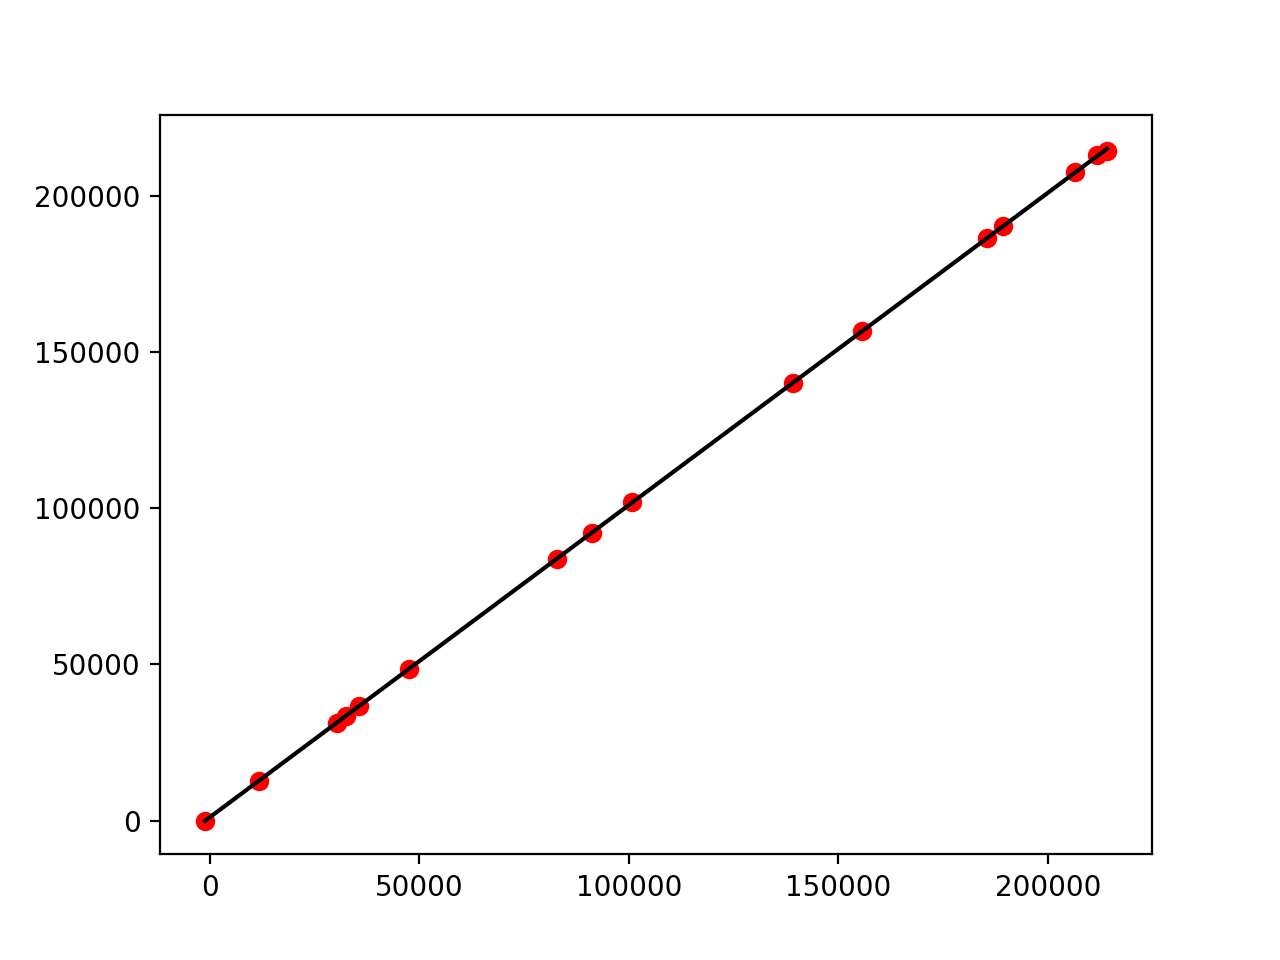

x0=-1162, y0=0, y_hat0=-26, offset=1563227340390
0.9990194246550355 1135.236697306682

using imageFlip (options are: imageFlip, normal, oddball)
Rejecting 0 out of 16 sample pairs.
Mean network delay: 77.00 ms (17.63 stdev)


In [19]:
msgs = ['imageFlip']
#msgs = ['good click', 'bad click', 'early click']
mad_scale = 10
predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, mad_scale=mad_scale, correct_delay=True, plot=True)

In [21]:
event_id = 998
eog_events = mne.preprocessing.find_eog_events(raw, event_id)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                       exclude='bads')



bias = int(round(200 / (1/.3)))
predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, mad_scale=mad_scale, correct_delay=True)

syn_event_df = pd.DataFrame([(i+bias,0,1) for i in predicted_eeg_samp], columns=['ts','diff','code'])
raw_no_ref,_ = mne.set_eeg_reference(raw.load_data().filter(l_freq=None, h_freq=45), [])
#raw_no_ref, _ = mne.set_eeg_reference(raw.load_data(), [])
reject = dict(eeg=150e-6) # 180e-6, eog=150e-6)
event_id, tmin, tmax = {'visual': 1}, -0.10, 0.5
epochs_params = dict(events=syn_event_df.values, event_id=event_id, tmin=tmin, tmax=tmax, reject=reject)
evoked_no_ref = mne.Epochs(raw_no_ref, **epochs_params, picks=picks).average()

predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, correct_delay=False)
syn_event_df = pd.DataFrame([(i+bias,0,1) for i in predicted_eeg_samp], columns=['ts','diff','code'])
epochs_params = dict(events=syn_event_df.values, event_id=event_id, tmin=tmin, tmax=tmax, reject=reject)
evoked_no_ref_uncorrected = mne.Epochs(raw_no_ref, **epochs_params, picks=picks).average()

EOG channel index for this subject is: [20]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 4096 samples (13.653 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition b

<IPython.core.display.Javascript object>


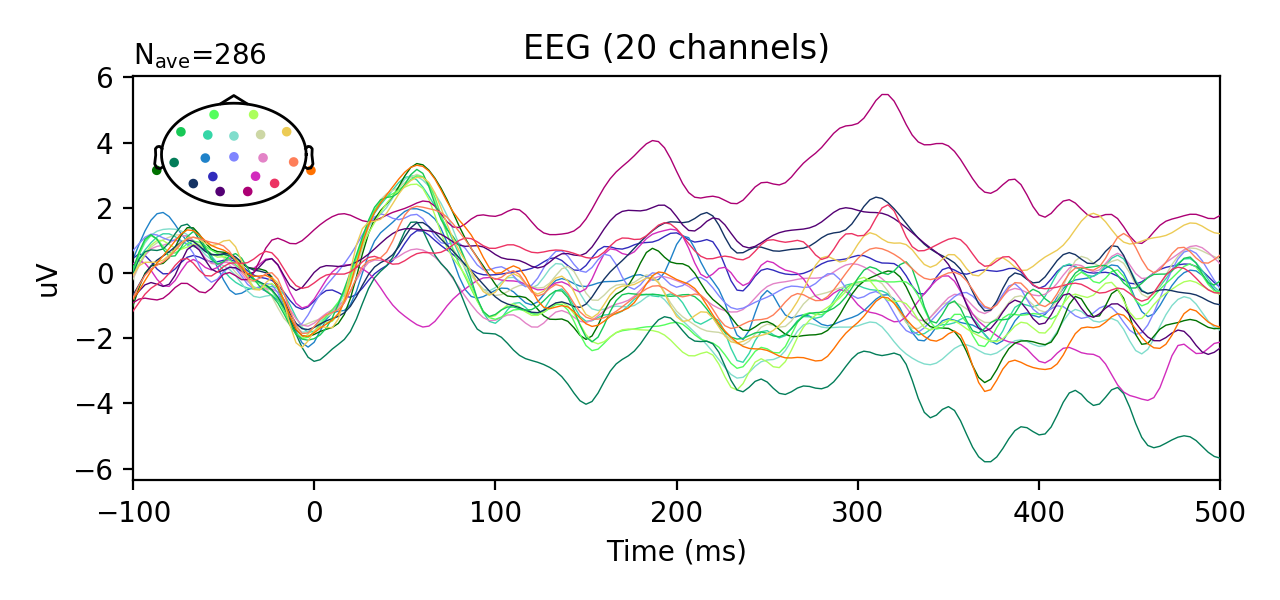

In [22]:
p = evoked_no_ref.plot(time_unit='ms', spatial_colors=True)

<IPython.core.display.Javascript object>


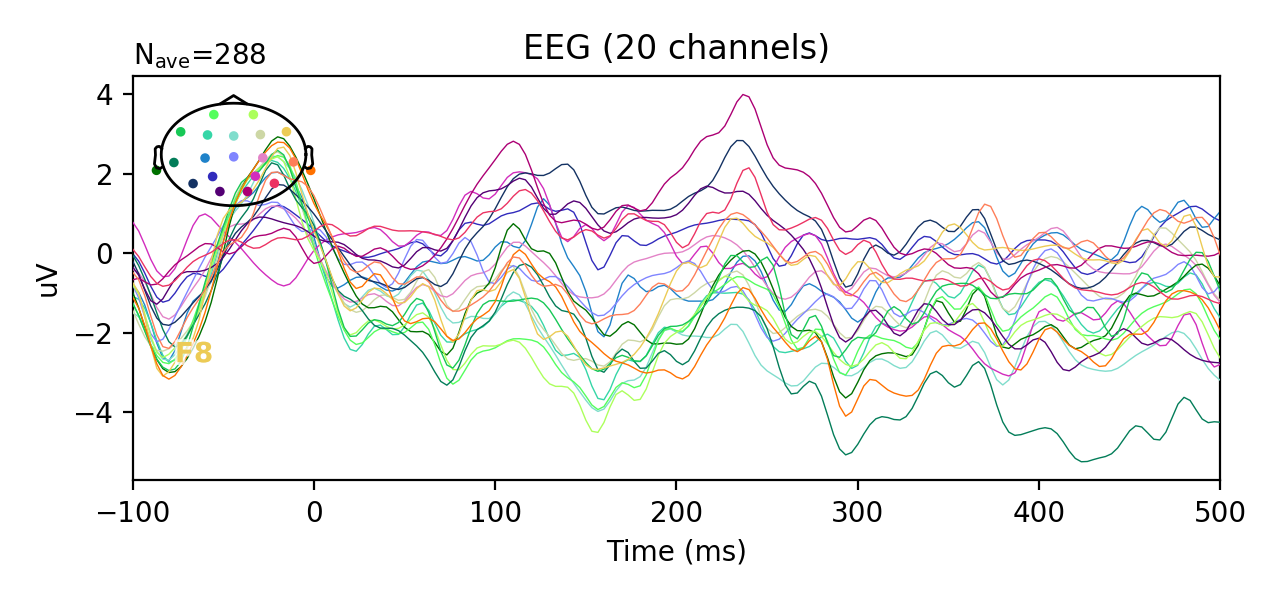

In [23]:
p = evoked_no_ref_uncorrected.plot(time_unit='ms', spatial_colors=True)